In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from config.config import Config
from models.binary_cnn.binary_cnn import ImprovedBinaryCNN, BinaryImageDataset, evaluate

In [2]:
log_file = Config.project_root / "notebooks" / "binary_cnn_inference.log"
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for more detailed logs
    format="%(asctime)s %(levelname)s: %(message)s",
    handlers=[
        logging.FileHandler(log_file, mode="a"),  # Append mode
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

In [3]:
def imshow(img_tensor, title=None):
    """Convert a tensor to a NumPy image (after unnormalizing) and display it."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

In [4]:
def run_inference_and_plot(target_class="fox", fold_model="fox_fold1_model.pth", num_samples_per_cat=8):
    """
    Runs inference on the test dataset for a given target class and plots a grid of sample images.
    It randomly selects 'num_samples_per_cat' samples from both positive and negative sets.
    Logs key steps.
    """
    # Define transform for inference
    inference_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Define path to test data for the target class
    test_dir = Config.DATA_DIR / target_class / "test"
    logger.info(f"Loading test dataset from {test_dir}")
    full_test_dataset = BinaryImageDataset(test_dir, transform=inference_transform)
    logger.info(f"Total test samples loaded: {len(full_test_dataset)}")
    
    # Separate indices for positive and negative samples
    pos_indices = [i for i, (_, label) in enumerate(full_test_dataset) if label.item() == 1]
    neg_indices = [i for i, (_, label) in enumerate(full_test_dataset) if label.item() == 0]
    logger.info(f"Found {len(pos_indices)} positive samples and {len(neg_indices)} negative samples in the test set.")
    
    # Randomly sample specified number of indices from each group
    sampled_pos = random.sample(pos_indices, min(num_samples_per_cat, len(pos_indices)))
    sampled_neg = random.sample(neg_indices, min(num_samples_per_cat, len(neg_indices)))
    sampled_indices = sampled_pos + sampled_neg
    logger.info(f"Selected {len(sampled_pos)} positive and {len(sampled_neg)} negative samples for visualization.")
    
    # Create a subset DataLoader for the selected indices
    subset_dataset = Subset(full_test_dataset, sampled_indices)
    subset_loader = DataLoader(subset_dataset, batch_size=len(sampled_indices), shuffle=False)
    
    # Initialize and load the model
    model = ImprovedBinaryCNN().to(Config.device)
    model_path = Config.WEIGHTS_DIR / fold_model
    logger.info(f"Loading model weights from {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=Config.device))
    model.eval()
    logger.info("Model loaded and set to evaluation mode.")
    
    # Define loss function (for evaluation purposes)
    criterion = nn.BCEWithLogitsLoss()
    
    # Evaluate on the subset
    test_loss, test_acc = evaluate(model, subset_loader, criterion, Config.device)
    logger.info(f"Subset Test Loss: {test_loss:.4f}, Subset Test Accuracy: {test_acc:.4f}")
    print(f"Subset Test Loss: {test_loss:.4f}, Subset Test Accuracy: {test_acc:.4f}")
    
    # Get the subset data for visualization
    dataiter = iter(subset_loader)
    images, labels = next(dataiter)
    images, labels = images.to(Config.device), labels.to(Config.device)
    
    with torch.no_grad():
        outputs = model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).float()
    
    # Plotting the images in a grid: if we have N positive + N negative, total = 2*N
    total_images = images.size(0)
    num_cols = 4
    num_rows = int(np.ceil(total_images / num_cols))
    
    plt.figure(figsize=(num_cols * 3, num_rows * 3))
    for idx in range(total_images):
        plt.subplot(num_rows, num_cols, idx+1)
        true_label = int(labels[idx].item())
        pred_label = int(preds[idx].item())
        # Mark the type as "Positive" if true label is 1, "Negative" otherwise
        label_str = "Positive" if true_label == 1 else "Negative"
        title = f"{label_str}\nTrue: {true_label} | Pred: {pred_label}"
        imshow(images[idx], title=title)
    plt.tight_layout()
    plt.show()
    logger.info("Inference and visualization completed.")

2025-01-31 23:13:02,210 INFO: Loading test dataset from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/data/resized_and_split/fox/test
2025-01-31 23:13:02,212 INFO: Total test samples loaded: 1300
2025-01-31 23:13:04,740 INFO: Found 650 positive samples and 650 negative samples in the test set.
2025-01-31 23:13:04,740 INFO: Selected 8 positive and 8 negative samples for visualization.
2025-01-31 23:13:04,844 INFO: Loading model weights from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/weights/fox_fold1_model.pth
2025-01-31 23:13:04,849 INFO: Model loaded and set to evaluation mode.
2025-01-31 23:13:05,006 INFO: Subset Test Loss: 0.6938, Subset Test Accuracy: 0.5625


Subset Test Loss: 0.6938, Subset Test Accuracy: 0.5625


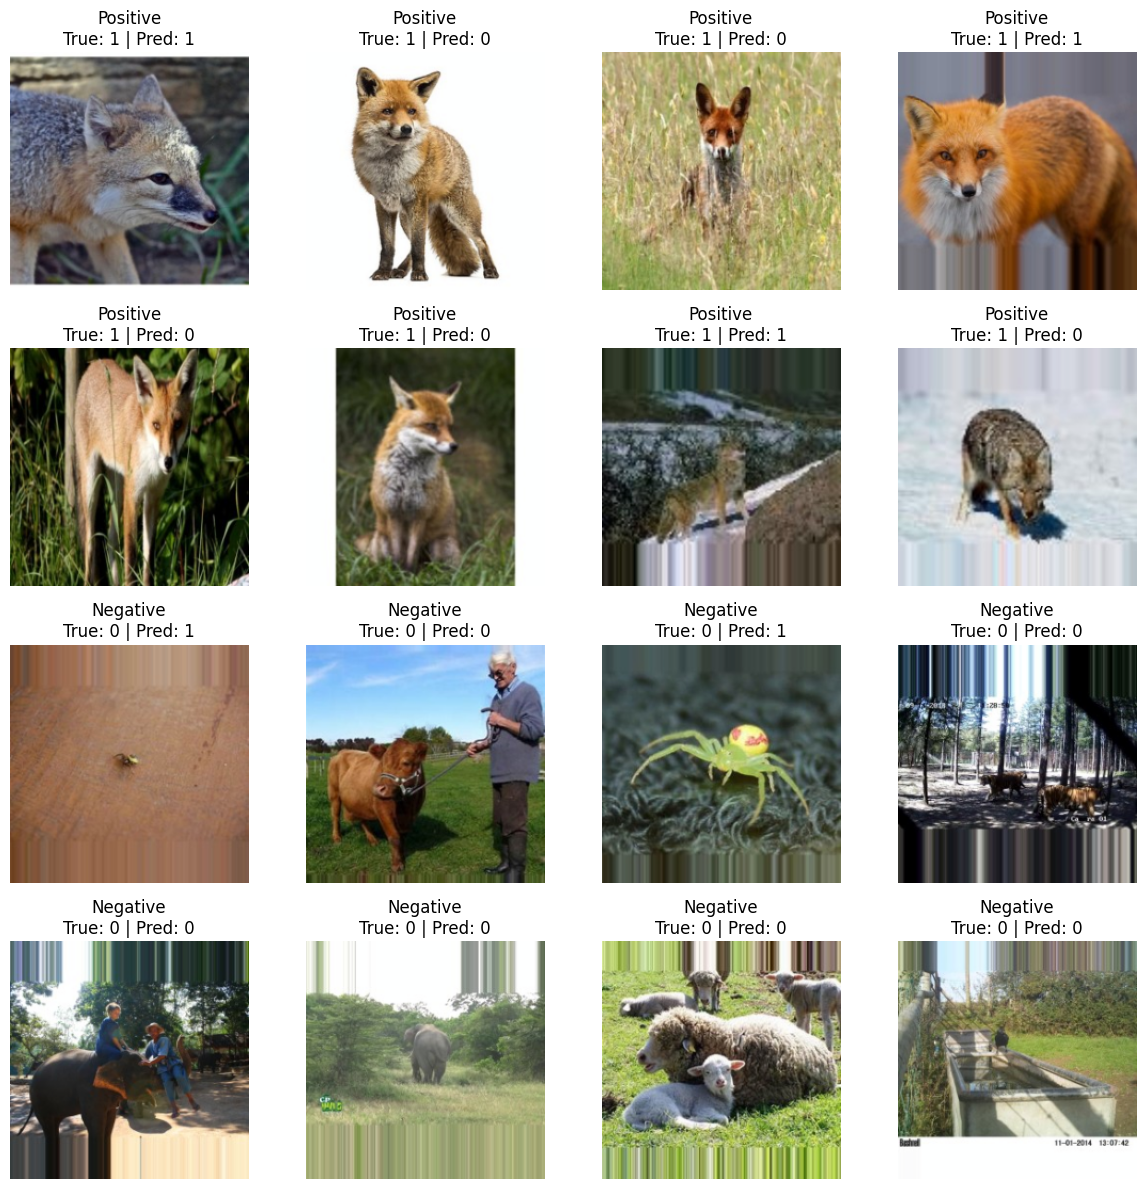

2025-01-31 23:13:05,546 INFO: Inference and visualization completed.


In [5]:
run_inference_and_plot(target_class="fox", fold_model="fox_fold1_model.pth", num_samples_per_cat=8)


2025-01-31 23:13:05,576 INFO: Loading test dataset from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/data/resized_and_split/fox/test
2025-01-31 23:13:05,581 INFO: Total test samples loaded: 1300
2025-01-31 23:13:08,135 INFO: Found 650 positive samples and 650 negative samples in the test set.
2025-01-31 23:13:08,135 INFO: Selected 8 positive and 8 negative samples for visualization.
2025-01-31 23:13:08,137 INFO: Loading model weights from /media/Ittwin/E/_uni/DL_Project/tiger-fox-elephant/weights/fox_fold2_model.pth
2025-01-31 23:13:08,140 INFO: Model loaded and set to evaluation mode.
2025-01-31 23:13:08,170 INFO: Subset Test Loss: 0.4677, Subset Test Accuracy: 0.9375


Subset Test Loss: 0.4677, Subset Test Accuracy: 0.9375


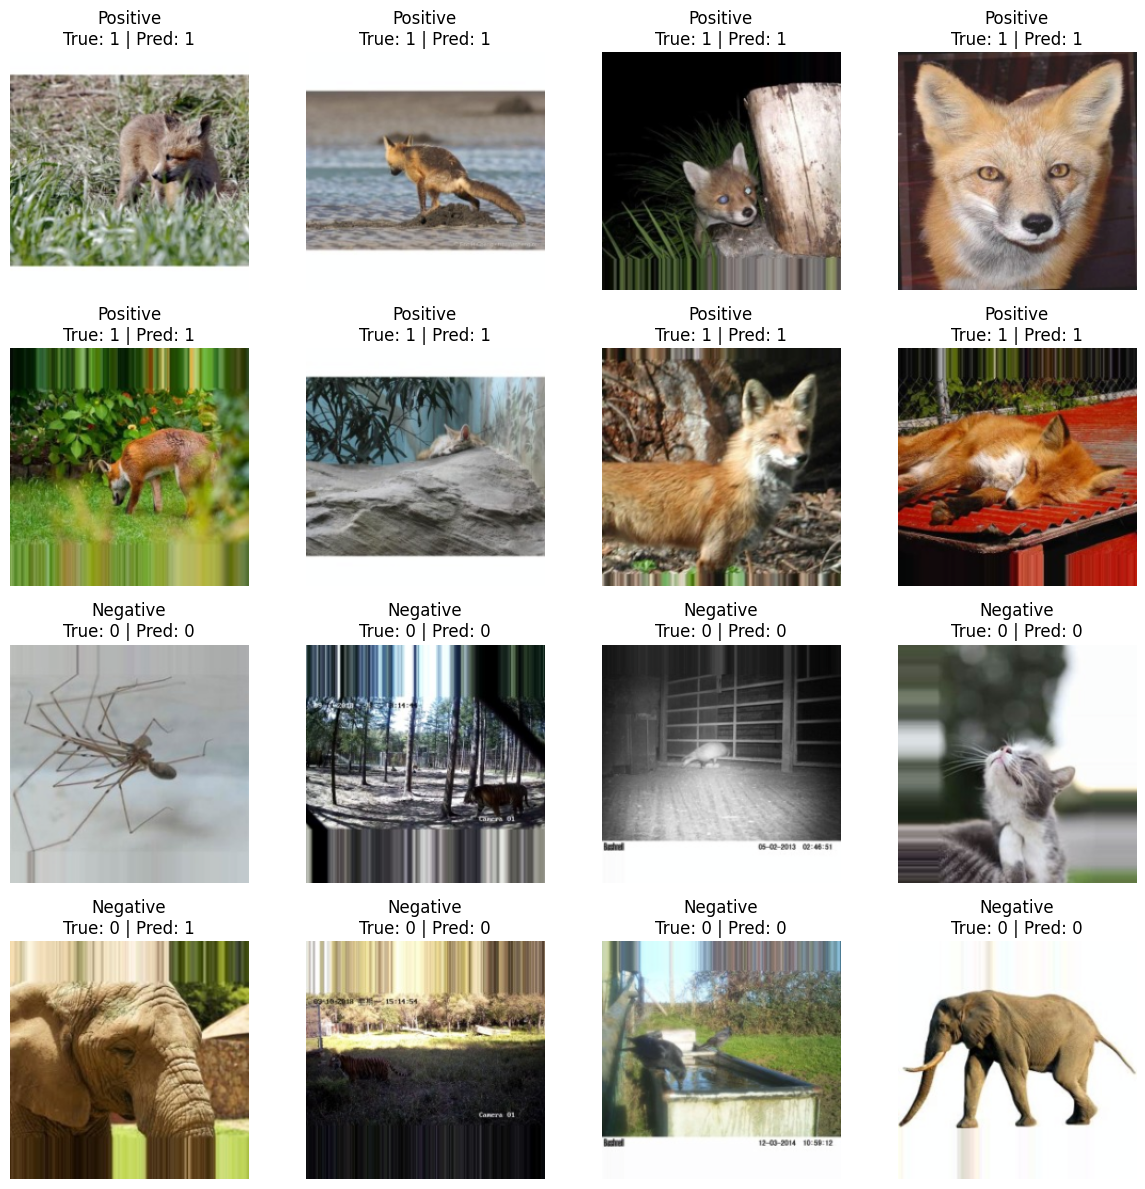

2025-01-31 23:13:08,634 INFO: Inference and visualization completed.


In [6]:
run_inference_and_plot(target_class="fox", fold_model="fox_fold2_model.pth", num_samples_per_cat=8)
